In [2]:
# Import necessary libraries
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from model.basenet import build_model, load_pretrain
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor
from tqdm import tqdm
from utils import preprocess
from utils.dataloader import ImageList
from utils.utils import build_config, set_seed

import numpy as np
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor
from tqdm import tqdm 
import torch
from torch import nn
	
from utils.utils import build_config
from utils.dataloader import ImageList

from model.basenet import build_model, load_pretrain
from sklearn.manifold import TSNE

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import (
	show_cam_on_image, deprocess_image, preprocess_image
)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
import matplotlib.animation as animation

class Visualize():
	def __init__(self, output_folder = ''):
		self.output_folder = output_folder
		os.makedirs(output_folder, exist_ok=True)

	def preprocess_image(self, img: np.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) -> torch.Tensor:
		"""
		Preprocess image: Convert to Tensor -> Normalize -> Transform to 4D.

		Input:
		- img: np.ndarray, Image need pre_processing.
		- mean: list, List value of mean to normalize.
		- std: list, List value of std to normalize.

		Output:
		- torch.Tensor, Image had pre_processed
		"""
		preprocessing = Compose([ToTensor(), Normalize(mean=mean, std=std)])
		return preprocessing(img.copy()).unsqueeze(0)

	def reshape_transform(self, tensor: torch.Tensor, height=14, width=14) -> torch.Tensor:
		"""
		Reshape and transpose the tensor for visualization.

		Input:
		- tensor: torch.Tensor, Value need reshape và transpose.
		- height: int, New height.
		- width: int, New width.

		Output:
		- torch.Tensor, tensor had reshaped and transposed.
		"""
		result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
		result = result.transpose(2, 3).transpose(1, 2)
		return result
	
	def scale_to_01_range(self, x):
		# compute the distribution range
		value_range = (np.max(x) - np.min(x))

		# move the distribution so that it starts from zero
		# by extracting the minimal value from all its values
		starts_from_zero = x - np.min(x)

		# make the distribution fit [0; 1] by dividing by its range
		return starts_from_zero / value_range

	def scale_feature(self, features, scale=True):
		'''
			Pre_process for feature: Scale feature TSNE to range (0, 1).
			(N, 2) => (N), (N)
		'''
		if not scale or np.max(features) <= 1:
			return features[:, 0], features[:, 1]
		x = self.scale_to_01_range(features[:, 0])
		y = self.scale_to_01_range(features[:, 1])
		return x, y

	def get_distinct_colors(self, num_colors):
		cmap = plt.get_cmap('hsv')
		colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
		return colors
	
	def save_img(self, img: np.ndarray, output_name: str, title=None):
		"""
		Save the image with optional title.

		Input:
		- img: np.ndarray, the image to be saved.
		- output_path: str, the path to save the image.
		- title: str (optional), the title of the image.

		Output:
		- None, this function saves the image to the provided path.
		"""
		if title is not None:
			plt.title(title)
		plt.imshow(img)
		plt.xticks([])
		plt.yticks([])
		plt.savefig(f'{self.output_folder}/{output_name}')

In [3]:
class Visualize_GradCam(Visualize):
	def __init__(self, output_folder='', dict_model={}):
		super().__init__(output_folder=output_folder)
		self.dict_model = dict_model
		
	def get_grad_cam(self, cam, rgb_img: np.ndarray, input_tensor: torch.Tensor, aug_smooth=True, eigen_smooth=True) -> np.ndarray:
		"""
		Generate Grad-CAM visualization and overlay it on the original image.

		Input:
		- cam: an object of the Grad-CAM class (or similar) used to generate Grad-CAM.
		- rgb_img: np.ndarray, the original RGB image.
		- input_tensor: torch.Tensor, the input tensor for calculating Grad-CAM.
		- aug_smooth: bool, option to use augmentation smoothing.
		- eigen_smooth: bool, option to use eigen smoothing.

		Output:
		- np.ndarray, the image with Grad-CAM overlayed on the original image.
		"""
		grayscale_cam = cam(input_tensor=input_tensor, targets=None, aug_smooth=aug_smooth, eigen_smooth=eigen_smooth)
		grayscale_cam = grayscale_cam[0, :]
		return show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
	
	def run(self, list_image_path = [], data_root = '', device='cpu'):
		# Set models to evaluation mode and create GradCAM instances
		cams = []
		for i, (key, model) in enumerate(self.dict_model.items()):
			# Visualize GRAD CAM on backbone (Not in Classifier)
			if "F1" in key or "F2" in key:
				continue

			model.eval()
			if 'G2' in key:
				# Use for ResNet based model
				cams.append(GradCAM(model=model, target_layers=[model.layer4[-1]]))
			elif 'G1' in key:
				# Use for ViT based model
				cams.append(GradCAM(model=model, target_layers=[model.blocks[-1].norm1], reshape_transform=self.reshape_transform))

		# Loop through images and generate Grad-CAM visualizations
		bar = tqdm(enumerate(list_image_path), total=len(list_image_path))
		label_prev = ""
		bar.set_description(label_prev)

		for i, path in bar:
			# Parse path and labels
			path_split = path.split("/")
			domain, label, image_name = path_split[0], path_split[1], path_split[-1][:-4]

			if label != label_prev:
				bar.set_description(label)
				label_prev = label

			# Load and preprocess image
			img = cv2.imread(os.path.join(data_root, path))[:, :, ::-1]
			img = cv2.resize(img, (224, 224))
			rgb_img = np.float32(img) / 255
			input_tensor = self.preprocess_image(rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
			input_tensor = input_tensor.to(device)

			# Generate Grad-CAM visualizations
			vises = [self.get_grad_cam(cam, rgb_img, input_tensor, aug_smooth=True, eigen_smooth=True) for cam in cams]

			# Create output directory
			output_path = f"/grad_cam/{domain}/{label}"
			os.makedirs(f"{self.output_folder}/{output_path}", exist_ok=True)

			# Save original and Grad-CAM images
			plt.figure(figsize=(20, 8))
			titles = ["Origin", "VIT_warmup", "CNN_warmup", "VIT_adapt", "CNN_adapt"]
			for title, img in zip(titles, [rgb_img] + vises):
				self.save_img(img, output_name=f"{output_path}/{label}_{title}.jpg")

			print(f"[INFO] Saved result in {output_path}")



In [19]:
class Visualize_TSNE(Visualize):
	def __init__(self, data_txt_path, list_class_id_to_show=None, output_folder = None) -> None:
		super().__init__(output_folder=output_folder)
		
		self.data_txt_path = data_txt_path
		# Get the class list from the data text file and store it
		self.class_list = self.return_classlist(data_txt_path)
		# If the class list is a list, convert it to a numpy array
		if isinstance(self.class_list, list):
			self.class_list = np.array(self.class_list)
		
		if list_class_id_to_show is not None:
			self.list_class_id_to_show = np.array(list_class_id_to_show) if isinstance(list_class_id_to_show, list) else list_class_id_to_show
		else:
			self.list_class_id_to_show = self.get_list_to_show(s=0, e=10)

		self.list_class_name_to_show = self.class_list[self.list_class_id_to_show]

	def get_list_to_show(self, s = 0, e = 10):
		"""
		Get a list of numbers or class IDs to show.

		Input:
		- s (int): Start index for the range (default is 0).
				If s is -1, the function will get top 10 IDs from a file.
		- e (int): End index for the range (default is 10).

		Output:
		- np.array: An array of numbers from s to e if s is not -1.
					If s is -1, an array of the top 10 most frequent class IDs from the file.
		"""

		if s != -1:
			return np.array(list(range(s, e)))
		else:
			with open(self.data_txt_path, 'r') as fi:
				data = list(map(lambda x: x.replace("\n", ""), fi.readlines()))

				# Extract the class IDs from the data by splitting each line and taking the last element,
				# then convert them to integers and store them in a list called class_ids.
				class_ids = list(map(lambda x: int(x.split(" ")[-1]), data))

				# Convert the class_ids list to a numpy array.
				class_ids = np.array(class_ids)

				# Get the unique class IDs and their frequencies using numpy's unique function.
				class_ids, freq = np.unique(class_ids, return_counts=True)

				# Create a dictionary mapping each class ID to its frequency.
				dct_class_freq = {class_id: f for class_id, f in zip(class_ids, freq)}

				# Sort the dictionary items by frequency in descending order.
				dct_class_freq = sorted(dct_class_freq.items(), key=lambda x: x[1], reverse=True)

				# Get the top 10 class IDs based on frequency and store them in a list called list_class_to_show.
				list_class_to_show = [class_id for class_id, _ in dct_class_freq[:10]]

			# Convert the list_class_to_show to a numpy array and return it.
			return np.array(list_class_to_show)

	def return_classlist(self, image_list):
		"""
		Extract a list of unique class labels from an image list file.

		Input:
		- image_list (str): Path to a file containing image paths and labels.

		Output:
		- np.array: An array of unique class labels extracted from the image list file.
		"""

		with open(image_list) as f:
			label_list = []
			
			# Iterate through each line in the file with an index.
			for ind, x in enumerate(f.readlines()):
				# Split the line by space, take the first part (image path),
				# then split by '/' and take the second last part as the label.
				label = x.split(' ')[0].split('/')[-2]
				
				# If the label is not already in the label_list,
				if label not in label_list:
					# Append the label to the label_list as a string.
					label_list.append(str(label))
					
		# Convert the label_list to a numpy array and return it.
		return np.array(label_list)

	
	def plot_confusion_matrix(self, conf_matrixs=[], normalize=True, annot=True, cmap='rocket_r', titles=[]):
		"""
		Plot confusion matrices stored in self.confusion_matrix.

		Input:
		- normalize (bool): Whether to normalize the confusion matrix.
		- annot (bool): Whether to annotate the heatmap with the numerical values.
		- cmap (str): Colormap to use for the heatmap.
		- titles (list): Titles for each confusion matrix plot.

		Output:
		- Displays and optionally saves the confusion matrix plot.
		"""
		
		if not isinstance(conf_matrixs, list):
			conf_matrixs = [conf_matrixs]

		if normalize:
			for conf_matrix in conf_matrixs:
				if isinstance(conf_matrix, torch.Tensor):
					# Convert it to a NumPy array.
					conf_matrix = conf_matrix.detach().cpu().numpy()
				# Normalize the confusion matrix by dividing each element by the sum of its row.
				conf_matrix = conf_matrix.astype('float') / (conf_matrix.sum(axis=1)[:, np.newaxis] + 1e-4)

		config_confm = {
			'data': conf_matrixs,
			'title': titles,
			'width': conf_matrixs[0].shape[0],
			'rotation': 90,
			'out_name': 'confusion_matrix.jpg',
			'fig_size': (30, 10),
			'cmap': cmap
		}

		# Create a subplot with shared x and y axes, and a defined figure size.
		fig, axn = plt.subplots(1, len(config_confm['data']),
								sharex=True, sharey=True,
								figsize=config_confm['fig_size'])
		
		# Add an axis for the color bar.
		cbar_ax = fig.add_axes([.91, .3, .03, .4])

		# Iterate over each subplot.
		for i, ax in enumerate(axn.flat):
			# Get the confusion matrix for the current subplot.
			confm = config_confm['data'][i]

			# Get the dimensions of the confusion matrix.
			y_width, x_width = confm.shape[0:2]

			# Plot the heatmap for the confusion matrix.
			sns.heatmap(confm, ax=ax,
						cbar=i == 0,
						vmin=0, vmax=1,
						cbar_ax=None if i else cbar_ax,
						annot=annot, cmap=config_confm['cmap'], fmt='.2f')

			# Set the x-axis ticks and labels with rotation.
			ax.set_xticks(list(range(0, x_width)), self.list_class_name_to_show, rotation=config_confm['rotation'])
			# Set the y-axis ticks and labels without rotation.
			ax.set_yticks(list(range(0, y_width)), self.list_class_name_to_show, rotation=0)
			# Set the title for the subplot.
			ax.set_title(config_confm['title'][i])

		# Uncomment this line to adjust subplot layout.
		# fig.tight_layout(rect=[0, 0, .9, 1])

		if self.output_folder is not None:
			# Save the figure to the specified output folder.
			plt.savefig(f'{self.output_folder}/{config_confm["out_name"]}')
		# Display the figure.
		plt.show()

	
	def visualize_tnse(self,features_tsne, labels_domain=None, labels_pred=None, output = None, scale=True):
		'''
		Visualize T-SNE for UDA
		param:
			num_classes: Number of classes in source domain
			features_tsne: Feature of T-SNE (2 dim)
			lables_domain: Label domain for each feature (0: Source domain, 1: Target domain)
			labels_pred: Label in predict for each feature
			output: Folder to save visualize
		'''
			
		def plot_tsne(idx, just_prototype=False, kwargs=None):
			for label_id, class_id in enumerate(self.list_class_id_to_show):
				
				label_index = np.where(labels_pred[idx] == class_id)

				# color = np.array(colors[label_id, ::-1], dtype=np.float32) / 255
				if not just_prototype:
					plt.scatter(x[idx][label_index], y[idx][label_index], 
							c=colors[label_id], 
							label=self.class_list[label_id], 
							marker=kwargs['marker_x'], 
							alpha=kwargs['alpha_x'])
			plt.legend()


		colors = ['green','blue','red','orange','purple','yellow','cyan','pink','silver','lawngreen']
		config_scatter = {
			'two_domain':{
				'color'  :['red','blue'],
				'color_proto'   :'black',
				'label'  :['Source Domain','Target Domain'],
				'marker' :['o','o'],
				'alpha'         :0.5,
				'alpha_proto'   :1,
				'size_proto'    :100
			},
			'each_domain':{
				'marker_x'      :'o',
				'marker_proto'  :'o',
				'alpha_x'       :0.5,
				'alpha_proto'   :1,
				'color_proto'   :'black',
				'size_proto'    :100
			}
		}
		output_path = "tsne"
		os.makedirs(f"{self.output_folder}/{output_path}", exist_ok=True)

		#### Visualize T-SNE on label domain ####
		x, y = self.scale_feature(features_tsne, scale=scale)

		idx_source = np.where(labels_domain == 0)[0]
		idx_target = np.where(labels_domain == 1)[0]

		if labels_pred is not None and len(idx_source) > 0:
			plt.figure(figsize=(10, 8))
			plt.title("Visualize T-SNE for each class in source domains")
			plot_tsne(idx=idx_source, kwargs=config_scatter['each_domain'])
			plt.savefig(f"{self.output_folder}/{output_path}/source_domain.jpg")

		if labels_pred is not None and len(idx_target) > 0:
			plt.figure(figsize=(10, 8))
			plt.title("Visualize T-SNE for each class in target domains")
			plot_tsne(idx=idx_target, kwargs=config_scatter['each_domain'])
			plt.savefig(f"{self.output_folder}/{output_path}/target_domain.jpg")

		if len(idx_source) > 0 and len(idx_target)>0:
			plt.figure(figsize=(10, 8))
			plt.title("Visualize T-SNE for two domains")

			for i, idx in enumerate([idx_source, idx_target]):
				for label_id, class_id in enumerate(self.list_class_id_to_show):
					label_index = np.where(labels_pred[idx] == class_id)
					plt.scatter(x[idx][label_index], y[idx][label_index], 
								c=config_scatter['two_domain']['color'][i], 
								label=config_scatter['two_domain']['label'][i], 
								marker=config_scatter['two_domain']['marker'][i], 
								alpha=config_scatter['two_domain']['alpha'])
			
			# plt.scatter(x[idx_target], y[idx_target],
			# 			c=config_scatter['two_domain']['color_target'], 
			# 			label=config_scatter['two_domain']['label_target'], 
			# 			marker=config_scatter['two_domain']['marker_target'], 
			# 			alpha=config_scatter['two_domain']['alpha'])

			handles, labels = plt.gca().get_legend_handles_labels()
			by_label = dict(zip(labels, handles))
			legend = plt.legend(by_label.values(), by_label.keys(),fontsize=20, handletextpad=0, labelspacing=0.1)
			# plt.legend()
			plt.savefig(f"{self.output_folder}/{output_path}/two_domain.jpg")

		#########################################

		plt.show()



In [5]:
def get_features(test_loader, dict_model, norm=False, DEVICE='cpu', is_target = True):
	###### Get features ######
	cnn_logit_all, vit_logit_all = None, None

	label_gt_all = None
	label_pred_cnn_all = None
	label_pred_vit_all = None

	for batch in tqdm(test_loader, desc='Running the model inference'):
		inputs, labels = batch['img_1'].to(DEVICE), batch['target']

		
		with torch.no_grad():
			vit_logit = dict_model['F1'](dict_model['G1'](inputs))
			cnn_logit = dict_model['F2'](dict_model['G2'](inputs))  

			
			_, predict_cnn = nn.Softmax(dim=1)(cnn_logit).max(1)
			_, predict_vit = nn.Softmax(dim=1)(vit_logit).max(1)

			vit_logit = vit_logit.detach().cpu().numpy()
			cnn_logit = cnn_logit.detach().cpu().numpy()


			labels = labels.detach().cpu().numpy()
			predict_cnn = predict_cnn.detach().cpu().numpy()
			predict_vit = predict_vit.detach().cpu().numpy()

		if cnn_logit_all is not None:
			cnn_logit_all = np.concatenate((cnn_logit_all, cnn_logit))
			vit_logit_all = np.concatenate((vit_logit_all, vit_logit)) 

			label_gt_all = np.concatenate((label_gt_all,labels))
			label_pred_cnn_all = np.concatenate((label_pred_cnn_all,predict_cnn))
			label_pred_vit_all = np.concatenate((label_pred_vit_all,predict_vit))

		else:
			cnn_logit_all = cnn_logit
			vit_logit_all = vit_logit 
			label_pred_cnn_all = predict_cnn
			label_pred_vit_all = predict_vit

			label_gt_all = labels
	
	if norm:
		cnn_logit_all = cnn_logit_all / np.linalg.norm(cnn_logit_all, axis=1, keepdims=True)
		vit_logit_all = vit_logit_all / np.linalg.norm(vit_logit_all, axis=1, keepdims=True)

	label_domain = np.ones(cnn_logit_all.shape[0]) if is_target else np.zeros(cnn_logit_all.shape[0])
		
	return cnn_logit_all, vit_logit_all, label_gt_all, label_domain, label_pred_cnn_all, label_pred_vit_all

In [6]:
# Load configuration and set seed
config = build_config("configs/visualize.yaml")
config_architecture = config["Architecture"]
set_seed(config["seed"])
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Pretrained model paths
# G1 = ViT - G2 = CNN
pretrain_paths = {
    "adapt_G1": "./pretrained_models/real_to_clipart_SSDA_3_baseline/the_best_G1.pth.tar",
    "adapt_F1": "./pretrained_models/real_to_clipart_SSDA_3_baseline/the_best_F1.pth.tar",
    "adapt_G2": "./pretrained_models/real_to_clipart_SSDA_3_baseline/the_best_G2.pth.tar",
    "adapt_F2": "./pretrained_models/real_to_clipart_SSDA_3_baseline/the_best_F2.pth.tar",
    "warmup_G1": "./pretrained_models/real_to_clipart_SSDA_3_pretrained_warmup/the_best_G1_pretrained.pth.tar",
    "warmup_F1": "./pretrained_models/real_to_clipart_SSDA_3_pretrained_warmup/the_best_F1_pretrained.pth.tar",
    "warmup_G2": "./pretrained_models/real_to_clipart_SSDA_3_pretrained_warmup/the_best_G2_pretrained.pth.tar",
    "warmup_F2": "./pretrained_models/real_to_clipart_SSDA_3_pretrained_warmup/the_best_F2_pretrained.pth.tar",
}

# Build and load models
G1_warmup, G2_warmup, F1_warmup, F2_warmup = build_model(config_architecture, DEVICE=DEVICE, pretrain=False)
G1_adapt, G2_adapt, F1_adapt, F2_adapt = build_model(config_architecture, DEVICE=DEVICE, pretrain=False)
models = {
    "warmup_G1": G1_warmup, 
    "warmup_F1": F1_warmup,
    "warmup_G2": G2_warmup,
    "warmup_F2": F2_warmup,
    "adapt_G1": G1_adapt,
    "adapt_F1": F1_adapt,
    "adapt_G2": G2_adapt,
    "adapt_F2": F2_adapt,
}

for i, (key, model) in enumerate(models.items()):
    if model is None:
        continue
    models[key] = load_pretrain(model, pretrain_path=pretrain_paths[key], device=DEVICE, init_weight=False)


Loading: /mnt/HDD1/tuong/workspace/FTC/pretrained_models/real_to_clipart_SSDA_3_pretrained_warmup/the_best_G1_pretrained.pth.tar
Pretrain weights VisionTransformer loaded.
Loading: /mnt/HDD1/tuong/workspace/FTC/pretrained_models/real_to_clipart_SSDA_3_pretrained_warmup/the_best_F1_pretrained.pth.tar
Pretrain weights Predictor_deep loaded.
Loading: /mnt/HDD1/tuong/workspace/FTC/pretrained_models/real_to_clipart_SSDA_3_pretrained_warmup/the_best_G2_pretrained.pth.tar
Pretrain weights ResNet loaded.
Loading: /mnt/HDD1/tuong/workspace/FTC/pretrained_models/real_to_clipart_SSDA_3_pretrained_warmup/the_best_F2_pretrained.pth.tar
Pretrain weights Predictor_deep loaded.
Loading: /mnt/HDD1/tuong/workspace/FTC/pretrained_models/real_to_clipart_SSDA_3_baseline/the_best_G1.pth.tar
Pretrain weights VisionTransformer loaded.
Loading: /mnt/HDD1/tuong/workspace/FTC/pretrained_models/real_to_clipart_SSDA_3_baseline/the_best_F1.pth.tar
Pretrain weights Predictor_deep loaded.
Loading: /mnt/HDD1/tuong/wor

# PLOT GRAD-CAM

canoe: 100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

[INFO] Saved result in /grad_cam/clipart/canoe


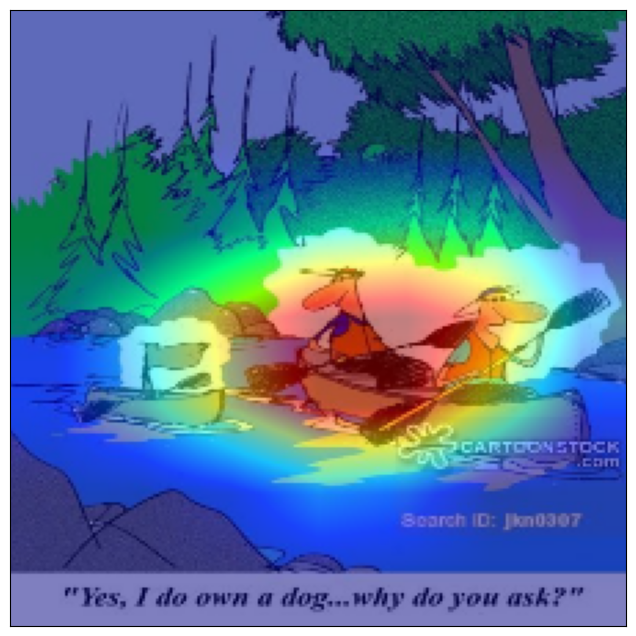

In [7]:
### PLOT GRAD CAM ###
# List of image paths to process
data_root = "/mnt/HDD1/tuong/workspace/Dataset/DomainNet"
img_paths = [
    'clipart/canoe/clipart_061_000041.jpg',
]

vis = Visualize_GradCam(output_folder = './visualize', dict_model=models)
vis.run(list_image_path=img_paths, data_root=data_root, device=DEVICE)

# PLOT TSNE

In [8]:
image_set_file_s_test = './dataset/domainnet_ssda/labeled_source_images_real.txt'
image_set_file_t_test = './dataset/domainnet_ssda/labeled_source_images_clipart.txt'
data_root = '../Dataset/DomainNet'
transform = preprocess.image_test(resize_size=256, crop_size=224)

target_test_dataset = ImageList(data_root=data_root,
                                data_path=image_set_file_t_test,
                                transform_w=transform,
                                use_cgct_mask=True)

source_test_dataset = ImageList(data_root=data_root, 
                                data_path=image_set_file_s_test,
                                transform_w=transform,
                                use_cgct_mask=True)

target_loader = DataLoader(dataset=target_test_dataset,
                        batch_size=64, 
                        shuffle=False,
                        num_workers=4,
                        pin_memory=True)

source_loader = DataLoader(dataset=source_test_dataset,
                        batch_size=64, 
                        shuffle=False,
                        num_workers=4,
                        pin_memory=True)


# config = build_config('configs/train.yaml')
# config_architecture = config['Architecture']
DEVICE='cuda:0'


###### Get features ######
dict_model = {
    'G1': models['warmup_G1'],
    'F1': models['warmup_F1'],
    'G2': models['warmup_G2'],
    'F2': models['warmup_F2']
}
# Get 10 class = True because to visualize TSNE
target_warmup_cnn_logit_all, target_warmup_vit_logit_all, target_label_gt_all, target_label_domain, target_label_pred_cnn_all, target_label_pred_vit_all = get_features(target_loader, dict_model=dict_model, is_target=True, norm=False, DEVICE=DEVICE)
source_warmup_cnn_logit_all, source_warmup_vit_logit_all, source_label_gt_all, source_label_domain, source_label_pred_cnn_all, source_label_pred_vit_all = get_features(source_loader, dict_model=dict_model, is_target=False, norm=False, DEVICE=DEVICE)
print("[INFO] Finished get feature")



Running the model inference:   2%|▏         | 7/293 [00:01<00:36,  7.90it/s]

Running the model inference: 100%|██████████| 1100/1100 [01:51<00:00,  9.86it/s]

[INFO] Finished get feature


[INFO] Finished concat data


[INFO] Finished get TSNE of feature


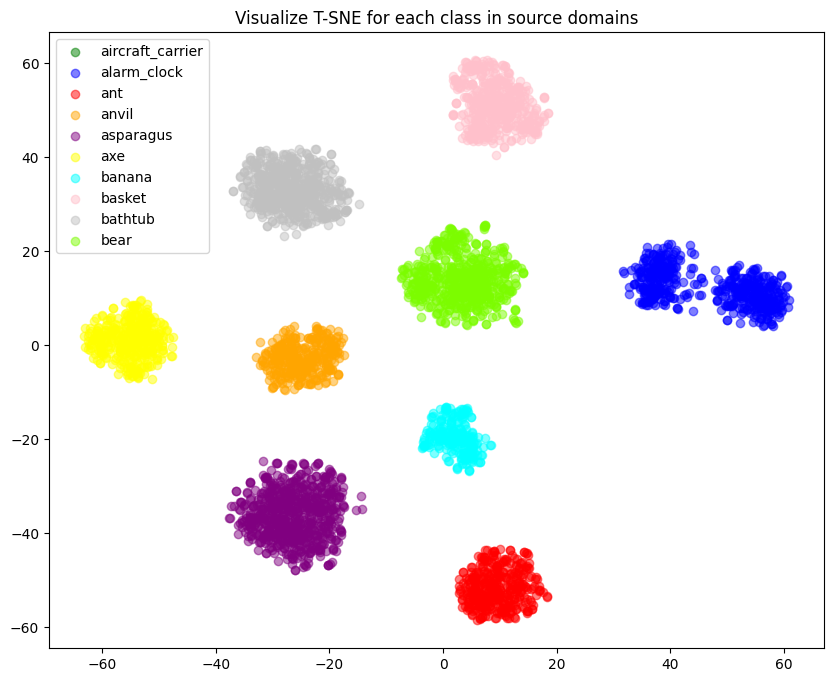

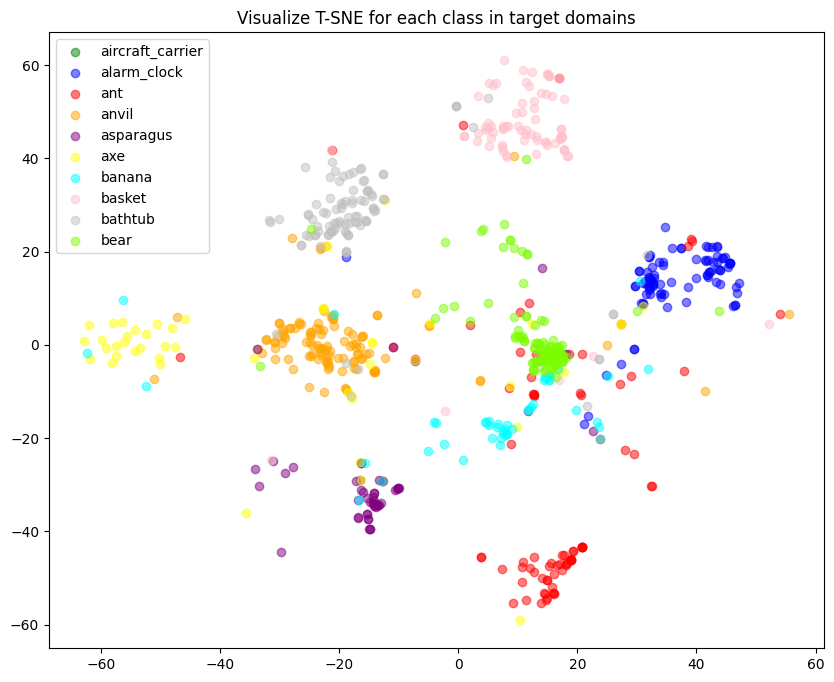

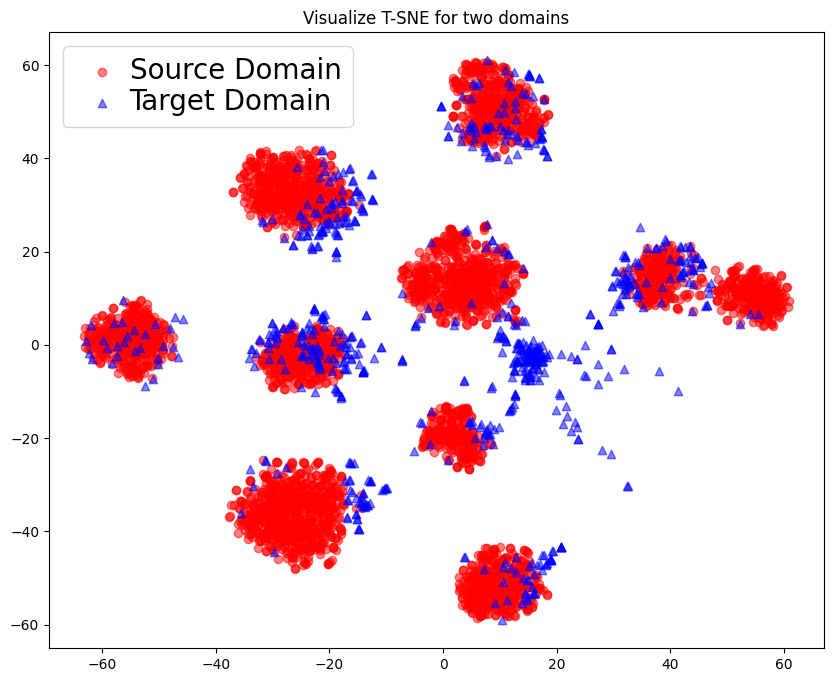

In [9]:
source_indices = np.where((source_label_gt_all >= 1) & (source_label_gt_all <= 10))[0]
source_warmup_cnn_logit_all_10 = source_warmup_cnn_logit_all[source_indices]
source_warmup_vit_logit_all_10 = source_warmup_vit_logit_all[source_indices]
source_label_gt_all_10 = source_label_gt_all[source_indices]
source_label_domain_10 = source_label_domain[source_indices]
source_label_pred_cnn_all_10 = source_label_pred_cnn_all[source_indices]
source_label_pred_vit_all_10 = source_label_pred_vit_all[source_indices]

target_indices = np.where((target_label_gt_all >= 1) & (target_label_gt_all <= 10))[0]
target_warmup_cnn_logit_all_10 = target_warmup_cnn_logit_all[target_indices]
target_warmup_vit_logit_all_10 = target_warmup_vit_logit_all[target_indices]
target_label_gt_all_10 = target_label_gt_all[target_indices]
target_label_domain_10 = target_label_domain[target_indices]
target_label_pred_cnn_all_10 = target_label_pred_cnn_all[target_indices]
target_label_pred_vit_all_10 = target_label_pred_vit_all[target_indices]

source_len = source_warmup_cnn_logit_all_10.shape[0]
labels_domain = np.concatenate((source_label_domain_10,target_label_domain_10))
label_gt_all = np.concatenate((source_label_gt_all_10,target_label_gt_all_10))
print("[INFO] Finished concat data")

warmup_cnn_logit_all_emb = TSNE(n_components=2, random_state=42).fit_transform(np.concatenate((source_warmup_cnn_logit_all_10, target_warmup_cnn_logit_all_10)))
warmup_vit_logit_all_emb = TSNE(n_components=2, random_state=42).fit_transform(np.concatenate((source_warmup_vit_logit_all_10, target_warmup_vit_logit_all_10)))
print('[INFO] Finished get TSNE of feature')


source_cnn_warmup_tsne = warmup_cnn_logit_all_emb[:source_len]
target_cnn_warmup_tsne = warmup_cnn_logit_all_emb[source_len:]

vis = Visualize_TSNE(data_txt_path=image_set_file_s_test,
                     output_folder='visualize')
					 
vis.visualize_tnse(features_tsne=np.concatenate((source_cnn_warmup_tsne, target_cnn_warmup_tsne)), 
                   labels_domain=labels_domain, 
                   labels_pred=label_gt_all, 
                   output='./',scale=False)

# PLOT CONFUSION MATRIX (10 classes)

[INFO] Finished get confusion_matrix
10 10
10 10


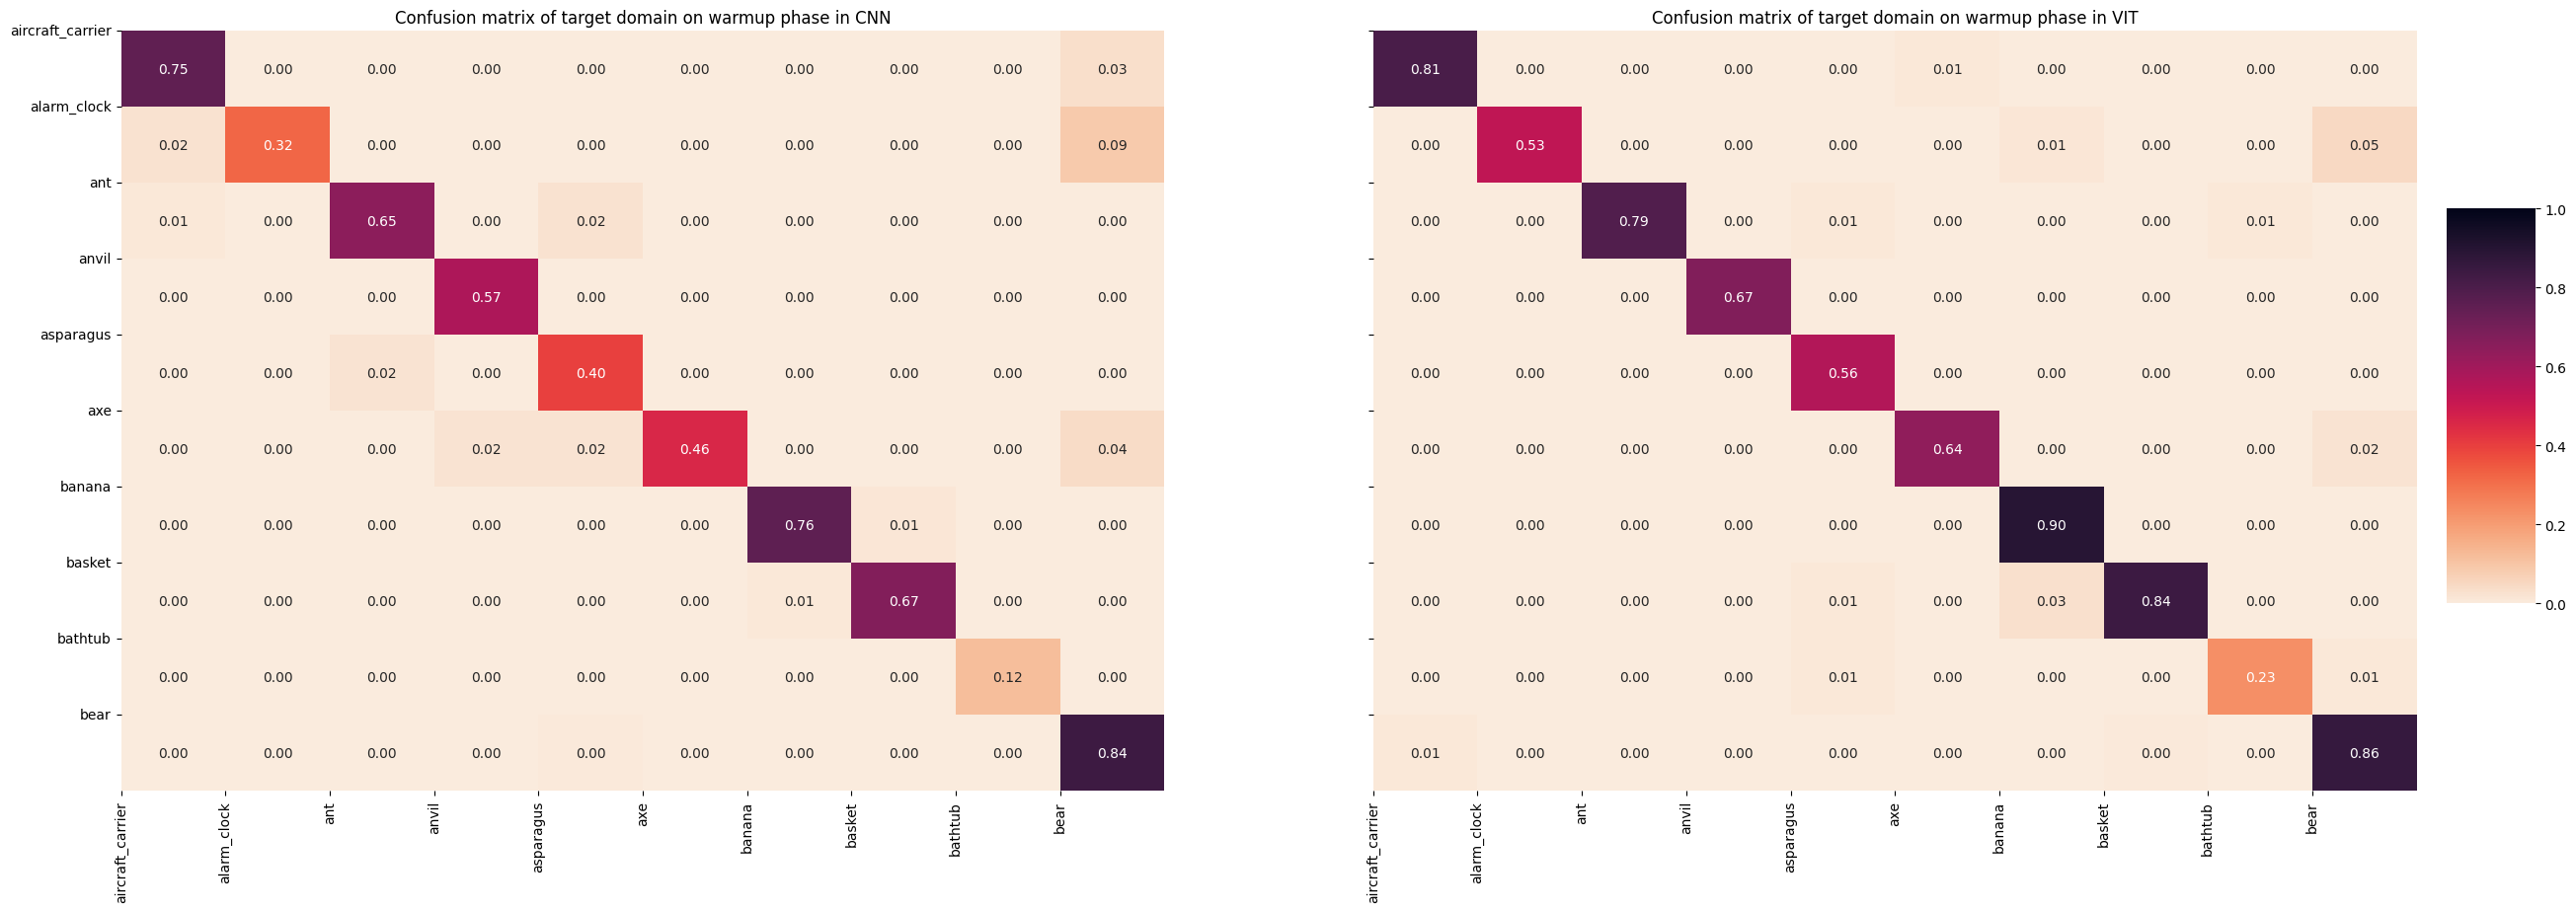

In [27]:
confm_target_cnn = confusion_matrix(target_label_gt_all_10, target_label_pred_cnn_all_10)
confm_target_cnn = confm_target_cnn.astype('float') / (confm_target_cnn.sum(axis=1)[:, np.newaxis]+1e-4)

confm_target_vit = confusion_matrix(target_label_gt_all_10, target_label_pred_vit_all_10)
confm_target_vit = confm_target_vit.astype('float') / (confm_target_vit.sum(axis=1)[:, np.newaxis]+1e-4)
print('[INFO] Finished get confusion_matrix')

vis = Visualize_TSNE(data_txt_path=image_set_file_s_test,
                     output_folder='visualize')
vis.plot_confusion_matrix(
	conf_matrixs = [confm_target_cnn[:10,:10], confm_target_vit[:10,:10]],
	normalize=True, annot=True, cmap='rocket_r', 
    titles=['Confusion matrix of target domain on warmup phase in CNN', 
            'Confusion matrix of target domain on warmup phase in VIT']
)